In [161]:
# Core
import numpy as np
import pandas as pd

# Models
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

# Model selection
from sklearn.model_selection import (
    StratifiedKFold,
    train_test_split,
    RandomizedSearchCV,
)

# Preprocessing and pipelines
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Metrics and evaluation
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    classification_report,
    confusion_matrix,
)
from sklearn.calibration import calibration_curve
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# Explainability
import shap


In [162]:
import pandas as pd

df = pd.read_csv("../data/sales_data.csv")

print(df.shape)
print(df.columns)
df.head()


(60000, 7)
Index(['order_id', 'product_id', 'product_category', 'price',
       'is_first_time_customer', 'order_day_of_week', 'returned'],
      dtype='object')


,order_id,product_id,product_category,price,is_first_time_customer,order_day_of_week,returned
0,ORD-1000,P-100,Engine,34.18,0,4,0
1,ORD-1001,P-101,Exhaust,54.07,1,0,0
2,ORD-1002,P-102,Brakes,46.28,0,6,0
3,ORD-1003,P-103,Filters,12.39,0,5,0
4,ORD-1004,P-104,Electronics,28.15,0,4,0


#  Data exploration and preprocessing

In [3]:
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   order_id                60000 non-null  object 
 1   product_id              60000 non-null  object 
 2   product_category        60000 non-null  object 
 3   price                   60000 non-null  float64
 4   is_first_time_customer  60000 non-null  int64  
 5   order_day_of_week       60000 non-null  int64  
 6   returned                60000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 3.2+ MB


In [4]:
df.isna().sum()

order_id                  0
product_id                0
product_category          0
price                     0
is_first_time_customer    0
order_day_of_week         0
returned                  0
dtype: int64

In [5]:
df.describe(include="all")  


,order_id,product_id,product_category,price,is_first_time_customer,order_day_of_week,returned
count,60000,60000,60000,60000.000000,60000.00000,60000.000000,60000.000000
unique,60000,200,7,NaN,NaN,NaN,NaN
top,ORD-1000,P-100,Engine,NaN,NaN,NaN,NaN
freq,1,300,12150,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,50.514736,0.30080,3.022533,0.089300
std,NaN,NaN,NaN,42.805604,0.45861,1.996178,0.285179
min,NaN,NaN,NaN,6.470000,0.00000,0.000000,0.000000
25%,NaN,NaN,NaN,24.360000,0.00000,1.000000,0.000000
50%,NaN,NaN,NaN,38.320000,0.00000,3.000000,0.000000
75%,NaN,NaN,NaN,61.820000,1.00000,5.000000,0.000000


In [6]:


def dataset_overview(df, unique_preview=20):
    def is_boolean(s):
        # exactly two distinct non-null values and they look boolean-ish
        vals = pd.Series(s.dropna().unique())
        if len(vals) != 2:
            return False
        norm = vals.astype(str).str.strip().str.lower()
        allowed = {"0","1","true","false","yes","no","y","n"}
        return set(norm).issubset(allowed)

    def is_id(s):
        # Mostly/fully unique, not datetime
        n = len(s)
        nunq = s.nunique(dropna=True)
        if pd.api.types.is_datetime64_any_dtype(s):
            return False
        # treat as ID if (almost) all unique or explicitly unique
        return nunq >= 0.95 * n or s.is_unique

    def is_constant(s):
        return s.nunique(dropna=True) == 1

    def is_ordinal(s):
        # 1) already an ordered categorical
        if pd.api.types.is_categorical_dtype(s) and getattr(s.dtype, "ordered", False):
            return True

        # 2) common ordered vocabularies (tweak as needed)
        ordered_maps = [
            ["low","medium","high","very high"],
            ["very low","low","medium","high","very high"],
            ["small","medium","large","x-large"],
            ["bronze","silver","gold","platinum","diamond"],
            ["poor","fair","good","very good","excellent"],
            ["beginner","intermediate","advanced","expert"]
        ]
        vals = s.dropna().astype(str).str.strip().str.lower().unique()
        vset = set(vals)
        for scale in ordered_maps:
            if vset.issubset(set(scale)) and len(vset) >= 2:
                return True
        # 3) pure integer codes with small range (e.g., 1<2<3)
        if pd.api.types.is_integer_dtype(s) and 2 <= s.nunique(dropna=True) <= 10:
            return True
        return False

    def safe_numeric_range(s):
        s_num = pd.to_numeric(s, errors="coerce")
        return (s_num.min(skipna=True), s_num.max(skipna=True))

    def iqr_outliers(s):
        s_num = pd.to_numeric(s, errors="coerce")
        s_num = s_num[np.isfinite(s_num)]
        if s_num.empty:
            return 0
        q1 = s_num.quantile(0.25)
        q3 = s_num.quantile(0.75)
        iqr = q3 - q1
        if iqr == 0:
            return 0
        lo = q1 - 1.5 * iqr
        hi = q3 + 1.5 * iqr
        return int(((s_num < lo) | (s_num > hi)).sum())

    def unique_preview_list(s, k):
        vals = s.dropna().unique()
        preview = list(vals[:k])
        if len(vals) > k:
            preview.append("…")
        return preview

    overview = []
    df_dup_rows = int(df.duplicated().sum())  # full-row duplicates (beyond first)

    for i, col in enumerate(df.columns):
        col_data = df[col]
        dtype = col_data.dtype
        n_null = int(col_data.isnull().sum())
        n_unique = int(col_data.nunique(dropna=True))

        # Type detection order: Constant → ID → Datetime → Boolean → Numeric → Ordinal → Categorical → Mixed
        if is_constant(col_data):
            col_type = "Constant"
            col_range = "-"
            outliers = "-"
        elif is_id(col_data):
            col_type = "ID"
            col_range = "-"
            outliers = "-"
        elif pd.api.types.is_datetime64_any_dtype(col_data):
            col_type = "Datetime"
            col_range = (col_data.min(), col_data.max())
            outliers = "-"
        elif is_boolean(col_data):
            col_type = "Boolean"
            col_range = "-"
            outliers = "-"
        elif pd.api.types.is_numeric_dtype(col_data) and n_unique > 2:
            col_type = "Numeric"
            col_range = (col_data.min(), col_data.max())
            outliers = iqr_outliers(col_data)
        elif is_ordinal(col_data):
            col_type = "Ordinal"
            col_range = "-"
            outliers = "-"
        else:
            # Mixed / Categorical fallback
            inferred = pd.api.types.infer_dtype(col_data, skipna=True)
            col_type = "Mixed" if inferred == "mixed" else "Categorical"
            col_range = "-"
            outliers = "-"

        # unique values (preview only)
        unique_values = unique_preview_list(col_data, unique_preview)

        overview.append({
            "Column": col,
            "Type": col_type,
            "Data Type": dtype,
            "Nulls": n_null,
            "Null %": round((n_null / len(df)) * 100, 2) if len(df) else 0.0,
            "#Unique Values": n_unique,
            "Unique values (sample)": unique_values,
            "Range (min, max)": col_range,
            "Outlier Count": outliers,
            # show the full-row duplicate count once (on the first column); blanks elsewhere
            "Duplicate Rows in DF": df_dup_rows if i == 0 else ""
        })

    return pd.DataFrame(overview)


overview_df = dataset_overview(df)
display(overview_df)




C:\Users\Parmiss\AppData\Local\Temp\ipykernel_10360\700306518.py:25: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(s) and getattr(s.dtype, "ordered", False):
C:\Users\Parmiss\AppData\Local\Temp\ipykernel_10360\700306518.py:25: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(s) and getattr(s.dtype, "ordered", False):


,Column,Type,Data Type,Nulls,Null %,#Unique Values,Unique values (sample),"Range (min, max)",Outlier Count,Duplicate Rows in DF
0,order_id,ID,object,0,0.0,60000,"[ORD-1000, ORD-1001, ORD-1002, ORD-1003, ORD-1...",-,-,0
1,product_id,Categorical,object,0,0.0,200,"[P-100, P-101, P-102, P-103, P-104, P-105, P-1...",-,-,
2,product_category,Categorical,object,0,0.0,7,"[Engine, Exhaust, Brakes, Filters, Electronics...",-,-,
3,price,Numeric,float64,0,0.0,13065,"[34.18, 54.07, 46.28, 12.39, 28.15, 27.21, 60....","(6.47, 1415.64)",3645,
4,is_first_time_customer,Boolean,int64,0,0.0,2,"[0, 1]",-,-,
5,order_day_of_week,Numeric,int64,0,0.0,7,"[4, 0, 6, 5, 2, 3, 1]","(0, 6)",0,
6,returned,Boolean,int64,0,0.0,2,"[0, 1]",-,-,


Dataset overview

Rows: 60,000

Target variable: returned (binary)

Return rate: ~8.93% (≈ 1 in 11 orders returned)

 Numerical Feature

price

Range: $6.47 – $1415.64

Mean ≈ $50, Median ≈ $38 → right-skewed distribution


Temporal Feature : order_day_of_week

Boolean Feature

is_first_time_customer

30% first-time buyers


 Categorical Features

product_category: 7 categories (low cardinality)
product_id: 200 unique products (medium- high cardinality, suitable for target/frequency encoding)

 Target

returned: 0 = not returned, 1 = returned

Imbalanced (≈9% positives) 
 Data Quality

No missing values

No duplicate rows

Clean feature types

C:\Users\Parmiss\AppData\Local\Temp\ipykernel_10360\3623824240.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="returned", data=df, palette="Set2")


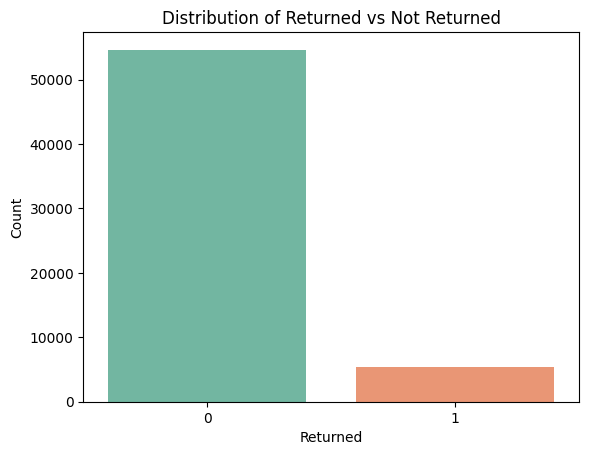

Return rate: 0.0893


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="returned", data=df, palette="Set2")
plt.title("Distribution of Returned vs Not Returned")
plt.xlabel("Returned")
plt.ylabel("Count")
plt.show()

print("Return rate:", df["returned"].mean())


Only ~9% of orders are returned.

=>class imbalance problem : accuracy alone will not be a meaningful metric. Precision, recall, F1, or ROC-AUC should be prioritized.

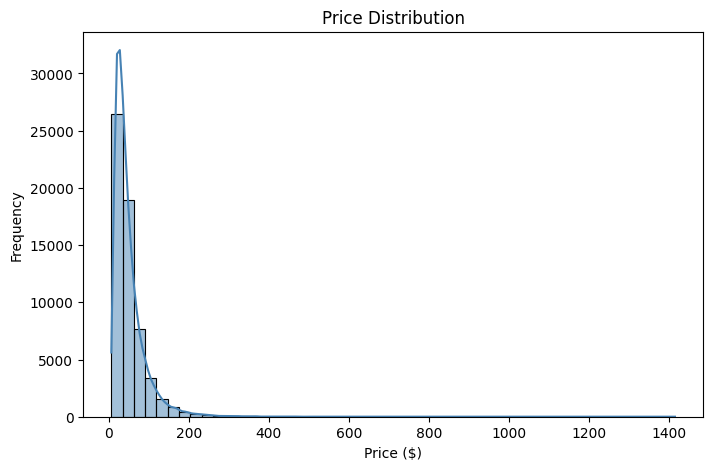

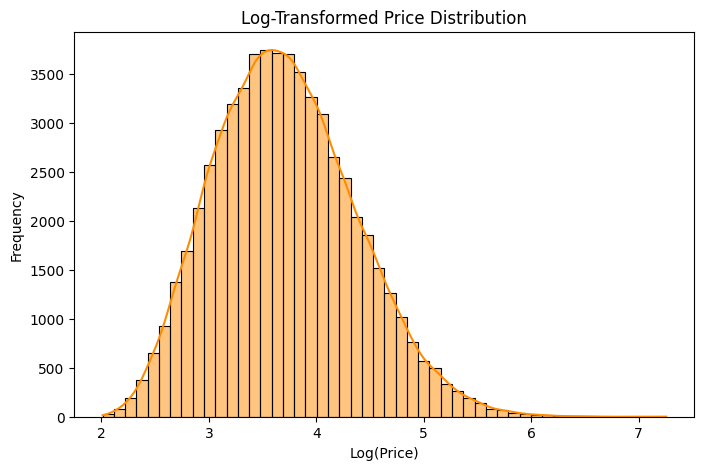

In [8]:
plt.figure(figsize=(8,5))
sns.histplot(df["price"], bins=50, kde=True, color="steelblue")
plt.title("Price Distribution")
plt.xlabel("Price ($)")
plt.ylabel("Frequency")
plt.show()

# Log-transformed (to handle skew/outliers)
plt.figure(figsize=(8,5))
sns.histplot(df["price"].apply(lambda x: np.log1p(x)), bins=50, kde=True, color="darkorange")
plt.title("Log-Transformed Price Distribution")
plt.xlabel("Log(Price)")
plt.ylabel("Frequency")
plt.show()


Most products are cheap (under $100), but a few very expensive items stretch the range up to $1400. => right skewed
Models like logistic regression can be sensitive to skew. Without transformation, the model might overemphasize the extreme prices.
log(price) is normal


C:\Users\Parmiss\AppData\Local\Temp\ipykernel_10360\3790494642.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="price_bucket", y="returned", data=df, ci=None, palette="coolwarm")
C:\Users\Parmiss\AppData\Local\Temp\ipykernel_10360\3790494642.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="price_bucket", y="returned", data=df, ci=None, palette="coolwarm")


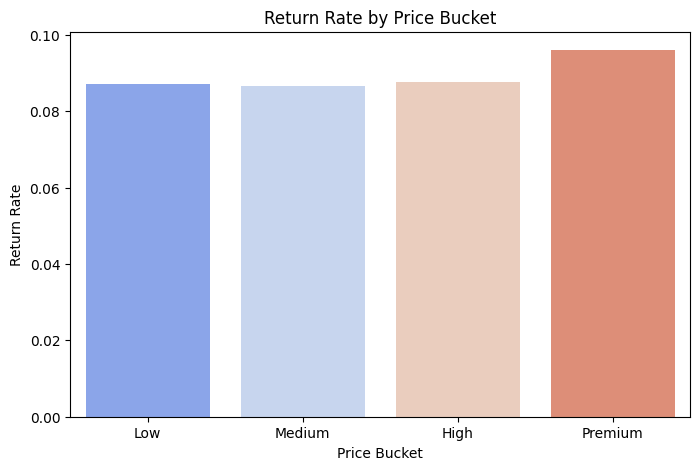

In [9]:
# Create buckets
df["price_bucket"] = pd.qcut(df["price"], q=4, labels=["Low", "Medium", "High", "Premium"])

plt.figure(figsize=(8,5))
sns.barplot(x="price_bucket", y="returned", data=df, ci=None, palette="coolwarm")
plt.title("Return Rate by Price Bucket")
plt.ylabel("Return Rate")
plt.xlabel("Price Bucket")
plt.show()


Customers are a bit more likely to return expensive items.

C:\Users\Parmiss\AppData\Local\Temp\ipykernel_10360\1600104945.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="is_first_time_customer", y="returned", data=df, ci=None, palette="mako")
C:\Users\Parmiss\AppData\Local\Temp\ipykernel_10360\1600104945.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="is_first_time_customer", y="returned", data=df, ci=None, palette="mako")


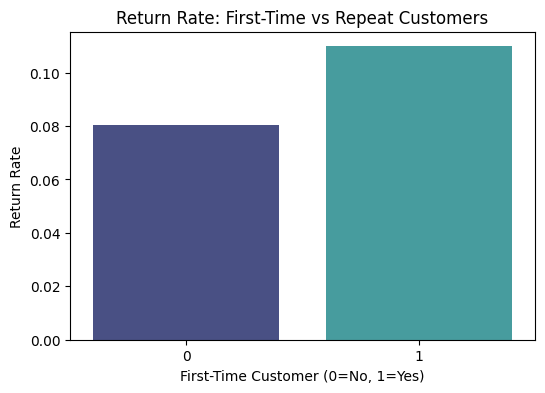

In [10]:
plt.figure(figsize=(6,4))
sns.barplot(x="is_first_time_customer", y="returned", data=df, ci=None, palette="mako")
plt.title("Return Rate: First-Time vs Repeat Customers")
plt.ylabel("Return Rate")
plt.xlabel("First-Time Customer (0=No, 1=Yes)")
plt.show()


In [11]:
print(df[df['is_first_time_customer']==1]['returned'].mean())

0.10981826241134751


In [12]:
print(df[df['is_first_time_customer']==0]['returned'].mean())

0.08047292143401984


First-time customers are more likely to return products (~11%) compared to repeat customers (~8%).

C:\Users\Parmiss\AppData\Local\Temp\ipykernel_10360\3402291969.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="order_day_of_week", y="returned", data=df, ci=None, palette="crest")
C:\Users\Parmiss\AppData\Local\Temp\ipykernel_10360\3402291969.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="order_day_of_week", y="returned", data=df, ci=None, palette="crest")


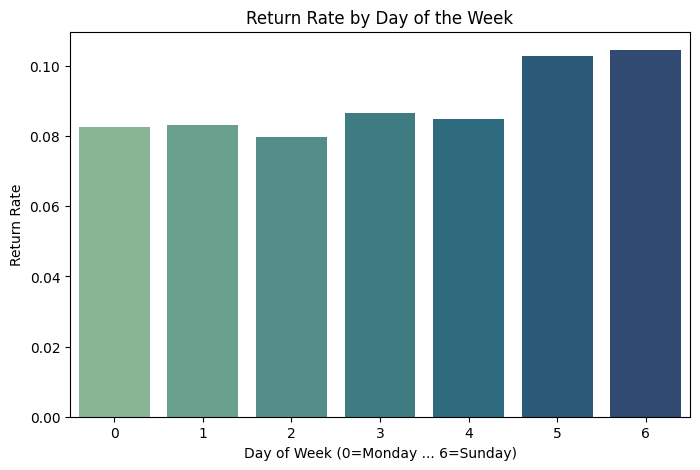

In [195]:
plt.figure(figsize=(8,5))
sns.barplot(x="order_day_of_week", y="returned", data=df, ci=None, palette="crest")
plt.title("Return Rate by Day of the Week")
plt.ylabel("Return Rate")
plt.xlabel("Day of Week (0=Monday ... 6=Sunday)")
plt.show()


In [196]:
df

,order_id,product_id,product_category,price,is_first_time_customer,order_day_of_week,returned
0,ORD-1000,P-100,Engine,34.18,0,4,0
1,ORD-1001,P-101,Exhaust,54.07,1,0,0
2,ORD-1002,P-102,Brakes,46.28,0,6,0
3,ORD-1003,P-103,Filters,12.39,0,5,0
4,ORD-1004,P-104,Electronics,28.15,0,4,0
...,...,...,...,...,...,...,...
59995,ORD-60995,P-295,Exhaust,218.68,1,0,0
59996,ORD-60996,P-296,Electronics,17.84,1,6,0
59997,ORD-60997,P-297,Filters,48.93,0,5,0
59998,ORD-60998,P-298,Brakes,91.52,0,4,0


Return rates are fairly stable from Monday to Thursday (~8–9%), but spike on weekends (Saturday ~10.2%, Sunday ~10.5%).

This could reflect impulse weekend purchases

In [ ]:
# Top 20 products by return rate
top20 = (
    df.groupby('product_id')
      .agg(
          number_of_orders = ('order_id', 'count'),
          number_of_returns = ('returned', 'sum'),
          return_rate = ('returned', 'mean')  # mean of 0/1 is the rate
      )
      .sort_values(['return_rate', 'number_of_orders'], ascending=[False, False])
      .head(20)
      .reset_index()
)

top20


,product_id,number_of_orders,number_of_returns,return_rate
0,P-203,300,40,0.133333
1,P-230,300,40,0.133333
2,P-199,300,39,0.130000
3,P-245,300,38,0.126667
4,P-288,300,38,0.126667
5,P-154,300,37,0.123333
6,P-206,300,36,0.120000
7,P-276,300,36,0.120000
8,P-182,300,35,0.116667
9,P-225,300,35,0.116667


C:\Users\Parmiss\AppData\Local\Temp\ipykernel_10360\2333958304.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


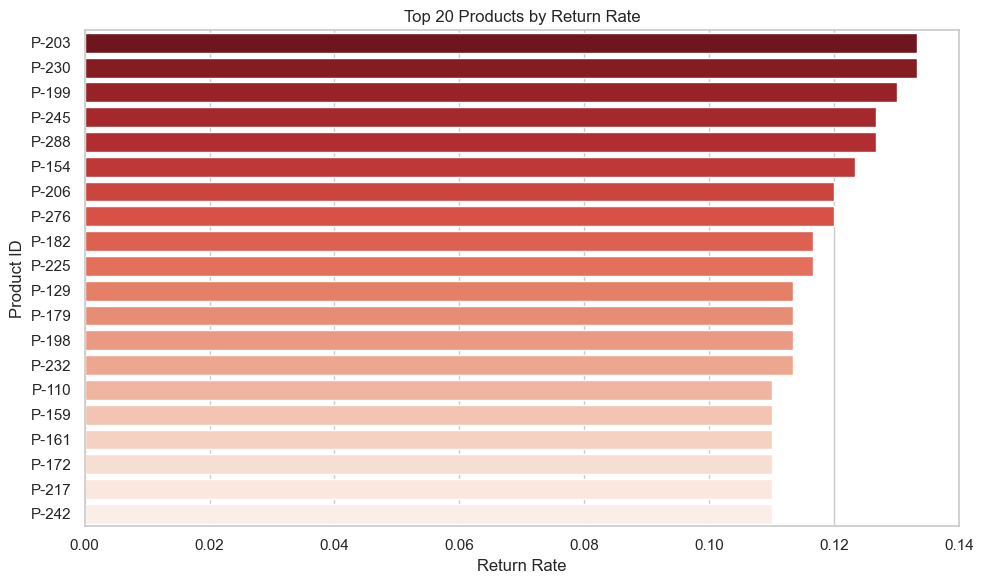

In [207]:

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top20,
    x="return_rate",
    y="product_id",
    palette="Reds_r"
)
plt.xlabel("Return Rate")
plt.ylabel("Product ID")
plt.title("Top 20 Products by Return Rate")
plt.tight_layout()
plt.show()

# Data Splitting

In [182]:
df = pd.read_csv('../data/sales_data.csv')
y = df["returned"]
X = df.drop(columns=["returned", "order_id"])  # drop ID


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [183]:
len(X_train)

48000

In [184]:
len(X_test)

12000

# Feature Engineering

model-agnostic feature engineering

In [185]:
def compute_feature_stats(X_train):
    stats = {}

    # price quantile edges (quartiles) from TRAIN only
    q = X_train["price"].quantile([0.0, 0.25, 0.50, 0.75, 1.0]).values
    edges = np.unique(q)  # guard against duplicate edges
    edges[0] = min(edges[0], X_train["price"].min())
    edges[-1] = max(edges[-1], X_train["price"].max())
    stats["price_edges"] = edges
    stats["price_bucket_labels"] = ["Low","Med","High","Premium"][:len(edges)-1]

    # product frequency map from TRAIN only
    stats["product_freq_map"] = X_train["product_id"].value_counts()

    # per-category price stats from TRAIN only (use raw price)
    stats["cat_price_stats"] = (
        X_train.groupby("product_category")["price"]
               .agg(mu="mean", sigma="std")
    )
    return stats

def apply_feature_engineering(X, stats):
    X = X.copy()
    # log price
    X["log_price"] = np.log1p(X["price"])
    # weekend flag
    X["is_weekend"] = X["order_day_of_week"].isin([5,6]).astype(int)
    # product freq (train map)
    X["product_freq"] = X["product_id"].map(stats["product_freq_map"]).fillna(0)
    X["log_product_freq"] = np.log1p(X["product_freq"])
    # price buckets (common edges)
    X["price_bucket"] = pd.cut(
        X["price"],
        bins=stats["price_edges"],
        labels=stats["price_bucket_labels"],
        include_lowest=True, right=True
    )
    # interaction
    X["first_time_x_log_price"] = X["is_first_time_customer"] * X["log_price"]
    # price z-score within category (using TRAIN stats)
    X = X.join(stats["cat_price_stats"], on="product_category")
    X["price_z_in_cat"] = (X["price"] - X["mu"]) / (X["sigma"].replace(0, 1.0))
    X.drop(columns=["mu","sigma"], inplace=True)
    # optional: fill NA if a category appears in test but not train
    X["price_z_in_cat"] = X["price_z_in_cat"].fillna(0.0)
    return X

# Use it
stats = compute_feature_stats(X_train)
X_train_fe = apply_feature_engineering(X_train, stats)
X_test_fe  = apply_feature_engineering(X_test,  stats)
X_train_fe.head()

,product_id,product_category,price,is_first_time_customer,order_day_of_week,log_price,is_weekend,product_freq,log_product_freq,price_bucket,first_time_x_log_price,price_z_in_cat
13532,P-232,Suspension,35.23,0,0,3.589888,0,238,5.476464,Med,0.000000,-0.353557
27096,P-196,Brakes,40.66,1,4,3.729541,0,243,5.497168,High,3.729541,-0.235147
19752,P-252,Suspension,43.86,1,3,3.803547,0,241,5.488938,High,3.803547,-0.143486
1843,P-143,Brakes,48.38,0,1,3.899545,0,233,5.455321,High,0.000000,-0.047607
10050,P-150,Brakes,40.95,0,2,3.736478,0,244,5.501258,High,0.000000,-0.228102


In [186]:
def oof_target_rate(X_train, y_train, X_test, key, m=50, n_splits=5, seed=42):
    y_train = y_train.rename("returned")
    global_rate = y_train.mean()
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    oof = np.full(len(X_train), np.nan, dtype=float)

    for tr_idx, va_idx in skf.split(X_train, y_train):
        df_tr = pd.DataFrame({key: X_train.iloc[tr_idx][key].values,
                              "returned": y_train.iloc[tr_idx].values})
        stats = df_tr.groupby(key)["returned"].agg(["mean","count"])
        smoothed = (stats["mean"]*stats["count"] + global_rate*m) / (stats["count"] + m)
        oof[va_idx] = X_train.iloc[va_idx][key].map(smoothed).fillna(global_rate).values

    df_full = pd.DataFrame({key: X_train[key].values, "returned": y_train.values})
    stats_full = df_full.groupby(key)["returned"].agg(["mean","count"])
    smoothed_full = (stats_full["mean"]*stats_full["count"] + global_rate*m) / (stats_full["count"] + m)
    test_enc = X_test[key].map(smoothed_full).fillna(global_rate).values
    return oof, test_enc

X_train_fe["product_return_rate"],  X_test_fe["product_return_rate"]  = oof_target_rate(X_train_fe, y_train, X_test_fe, "product_id", m=50)
X_train_fe["category_return_rate"], X_test_fe["category_return_rate"] = oof_target_rate(X_train_fe, y_train, X_test_fe, "product_category", m=50)


# Model Selection

# Logistic Regression

In [210]:
#Logistic Regression (baseline): fast, interpretable, sets a performance floor


num_cols  = ["log_price", "log_product_freq", "product_return_rate",
             "category_return_rate", "first_time_x_log_price", "price_z_in_cat"]
cat_cols  = ["price_bucket"]  # keep simple; you can try adding "product_category" later
bool_cols = ["is_first_time_customer", "is_weekend"]


X_train_res, y_train_res = (X_train_fe, y_train)

# 1) Make a small validation split from TRAIN
X_tr2, X_val2, y_tr2, y_val2 = train_test_split(
    X_train_res, y_train_res, test_size=0.2, stratify=y_train_res, random_state=42
)

preproc = ColumnTransformer([
    ("num",  StandardScaler(), num_cols),
    ("cat",  OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("bool", "passthrough", bool_cols),
])


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



lr = Pipeline([ ("prep", preproc), ("clf", LogisticRegressionCV( Cs=20, cv=skf, scoring="average_precision", class_weight="balanced", penalty="l2", solver="liblinear", max_iter=5000 )) ])
# 2) Refit the same pipeline on this reduced train
lr.fit(X_tr2, y_tr2)

# 3) Choose threshold on validation by max F1
p_val = lr.predict_proba(X_val2)[:, 1]
prec, rec, thr = precision_recall_curve(y_val2, p_val)
f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
t_best = thr[np.nanargmax(f1[:-1])]  # thresholds array is len-1 of prec/rec

print(f"Chosen threshold (max F1 on val): {t_best:.3f}")

# 4) Evaluate on TEST at that threshold (refit on full train first)
lr.fit(X_train_fe, y_train)
p_test = lr.predict_proba(X_test_fe)[:, 1]
y_pred = (p_test >= t_best).astype(int)

print("Test ROC-AUC:", roc_auc_score(y_test, p_test))
print("Test PR-AUC :", average_precision_score(y_test, p_test))
print(f"\nClassification report @{t_best:.3f}:\n", classification_report(y_test, y_pred, digits=3))
print(f"Confusion matrix @{t_best:.3f}:\n", confusion_matrix(y_test, y_pred))
# Capacity view: top-k precision/recall/lift
def topk_metrics(y_true, y_proba, k=0.10):
    cut = np.quantile(y_proba, 1-k)
    y_hat = (y_proba >= cut).astype(int)
    P = (y_true==1).sum()
    TP = ((y_true==1) & (y_hat==1)).sum()
    FP = ((y_true==0) & (y_hat==1)).sum()
    precision = TP / max(TP+FP, 1)
    recall = TP / max(P, 1)
    lift = precision / (y_true.mean() + 1e-12)
    return precision, recall, lift, cut, y_hat.sum()

for k in [0.05, 0.10, 0.15]:
    prc, rcl, lft, cut, nflag = topk_metrics(y_test.values, p_test, k=k)
    print(f"Top {int(k*100)}%  Precision={prc:.3f}  Recall={rcl:.3f}  Lift={lft:.1f}x  "
          f"Threshold≈{cut:.3f}  Flagged={nflag}")


Chosen threshold (max F1 on val): 0.516
Test ROC-AUC: 0.6045376640998885
Test PR-AUC : 0.13159385454381783

Classification report @0.516:
               precision    recall  f1-score   support

           0      0.929     0.763     0.838     10928
           1      0.142     0.401     0.210      1072

    accuracy                          0.731     12000
   macro avg      0.535     0.582     0.524     12000
weighted avg      0.858     0.731     0.782     12000

Confusion matrix @0.516:
 [[8338 2590]
 [ 642  430]]
Top 5%  Precision=0.178  Recall=0.100  Lift=2.0x  Threshold≈0.682  Flagged=600
Top 10%  Precision=0.165  Recall=0.185  Lift=1.8x  Threshold≈0.606  Flagged=1200
Top 15%  Precision=0.158  Recall=0.266  Lift=1.8x  Threshold≈0.596  Flagged=1800


## XGBoost

In [209]:

num_cols  = ["log_price", "log_product_freq", "first_time_x_log_price", "price_z_in_cat",'product_return_rate']
cat_cols  = ["price_bucket",'product_category']   

preproc_tree = ColumnTransformer([
    ("num",  "passthrough", num_cols),
    ("cat",  OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("bool", "passthrough", bool_cols),
])

# Imbalance handling
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
X_tr2, X_val2, y_tr2, y_val2 = train_test_split(
    X_train_fe, y_train, test_size=0.5, stratify=y_train, random_state=42
)

preproc_tree.fit(X_tr2)
X_tr2_proc  = preproc_tree.transform(X_tr2)
X_val2_proc = preproc_tree.transform(X_val2)
X_test_proc = preproc_tree.transform(X_test_fe)


xgb = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=4,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=10.0,
    reg_alpha=1.0,
    scale_pos_weight=pos_weight,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
    tree_method="hist",
    early_stopping_rounds=100,
)

xgb.fit(
    X_tr2_proc, y_tr2,
    eval_set=[(X_val2_proc, y_val2)],
    
    verbose=False
)

# choose operating threshold on the validation set
p_val = xgb.predict_proba(X_val2_proc)[:, 1]
prec, rec, thr = precision_recall_curve(y_val2, p_val)
f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
t_best = thr[np.nanargmax(f1[:-1])]
print(f"Chosen threshold (max F1 on val): {t_best:.3f}")
print(f"Validation F1 score: {np.nanmax(f1[:-1]):.3f}")


# Evaluate on test t
p_test = xgb.predict_proba(X_test_proc)[:, 1]
y_pred = (p_test >= t_best).astype(int)

print(f"\nClassification report @{t_best:.3f}:\n",
      classification_report(y_test, y_pred, digits=3))
print(f"Confusion matrix @{t_best:.3f}:\n", confusion_matrix(y_test, y_pred))

# Use probabilities for AUCs:
print("final XGB Test ROC-AUC:", roc_auc_score(y_test, p_test))
print("final XGB Test PR-AUC :", average_precision_score(y_test, p_test))
# Capacity view: top-k precision/recall/lift
def topk_metrics(y_true, y_proba, k=0.10):
    cut = np.quantile(y_proba, 1-k)
    y_hat = (y_proba >= cut).astype(int)
    P = (y_true==1).sum()
    TP = ((y_true==1) & (y_hat==1)).sum()
    FP = ((y_true==0) & (y_hat==1)).sum()
    precision = TP / max(TP+FP, 1)
    recall = TP / max(P, 1)
    lift = precision / (y_true.mean() + 1e-12)
    return precision, recall, lift, cut, y_hat.sum()

for k in [0.05, 0.10, 0.15]:
    prc, rcl, lft, cut, nflag = topk_metrics(y_test.values, p_test, k=k)
    print(f"Top {int(k*100)}%  Precision={prc:.3f}  Recall={rcl:.3f}  Lift={lft:.1f}x  "
          f"Threshold≈{cut:.3f}  Flagged={nflag}")


Chosen threshold (max F1 on val): 0.529
Validation F1 score: 0.194

Classification report @0.529:
               precision    recall  f1-score   support

           0      0.925     0.787     0.850     10928
           1      0.138     0.349     0.198      1072

    accuracy                          0.747     12000
   macro avg      0.532     0.568     0.524     12000
weighted avg      0.855     0.747     0.792     12000

Confusion matrix @0.529:
 [[8595 2333]
 [ 698  374]]
final XGB Test ROC-AUC: 0.5750542304719084
final XGB Test PR-AUC : 0.1190593770684803
Top 5%  Precision=0.137  Recall=0.076  Lift=1.5x  Threshold≈0.670  Flagged=600
Top 10%  Precision=0.147  Recall=0.165  Lift=1.7x  Threshold≈0.623  Flagged=1200
Top 15%  Precision=0.144  Recall=0.243  Lift=1.6x  Threshold≈0.584  Flagged=1800


In [ ]:
# === Random Forest for Product Returns (PR-AUC optimized), end-to-end ===

# ------------------------------------------------------------
# 3) Random Forest pipeline + hyperparameter tuning (PR-AUC)
#    Trees don't need OHE for price_bucket; use dense features directly.
# ------------------------------------------------------------
num_cols_tree  = ["price", "log_price", "log_product_freq",
                  "product_return_rate", "category_return_rate",
                  "first_time_x_log_price", "price_z_in_cat"]
bool_cols_tree = ["is_first_time_customer", "is_weekend"]

preproc_rf = ColumnTransformer([
    ("num",  "passthrough", num_cols_tree),
    ("bool", "passthrough", bool_cols_tree),
])

rf_base = Pipeline([
    ("prep", preproc_rf),
    ("clf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

param_distributions = {
    "clf__n_estimators":      [200, 300, 400],
    "clf__max_depth":         [None, 8, 12, 16, 24],
    "clf__min_samples_split": [2, 5, 10, 20],
    "clf__min_samples_leaf":  [1, 2, 4, 8],
    "clf__max_features":      ["sqrt", "log2", 0.5, 0.7],
    "clf__bootstrap":         [True],
    "clf__class_weight":      ["balanced_subsample", "balanced"],
    "clf__ccp_alpha":         [0.0, 1e-4, 1e-3],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rf_search = RandomizedSearchCV(
    rf_base,
    param_distributions=param_distributions,
    n_iter=20,                      # increase to 40–60 if you want a deeper search
    scoring="average_precision",    # PR-AUC
    cv=cv,
    random_state=42,
    n_jobs=-1,
    refit=True,
    verbose=1
)

rf_search.fit(X_train_fe, y_train)
best_rf = rf_search.best_estimator_
print("Best RF params:", rf_search.best_params_)
print("Best CV PR-AUC:", rf_search.best_score_)

X_tr2, X_val2, y_tr2, y_val2 = train_test_split(
    X_train_fe, y_train, test_size=0.2, stratify=y_train, random_state=42
)
best_rf.fit(X_tr2, y_tr2)
p_val = best_rf.predict_proba(X_val2)[:, 1]

prec, rec, thr = precision_recall_curve(y_val2, p_val)
F1 = 2*(prec*rec)/(prec+rec+1e-12)
t_star = thr[np.nanargmax(F1[:-1])]
print(f"Chosen threshold (max-F1 on val): {t_star:.3f}")

# Refit on FULL TRAIN and score
best_rf.fit(X_train_fe, y_train)

p_train = best_rf.predict_proba(X_train_fe)[:, 1]
p_test  = best_rf.predict_proba(X_test_fe)[:, 1]

print("Train ROC-AUC:", roc_auc_score(y_train, p_train))
print("Train PR-AUC :", average_precision_score(y_train, p_train))
print("Test ROC-AUC :", roc_auc_score(y_test,  p_test))
print("Test PR-AUC  :", average_precision_score(y_test,  p_test))

yhat_test = (p_test >= t_star).astype(int)
print("\nTest report @t*:\n", classification_report(y_test, yhat_test, digits=3))
print("Test confusion @t*:\n", confusion_matrix(y_test, yhat_test))

# Capacity view: top-k precision/recall/lift
def topk_metrics(y_true, y_proba, k=0.10):
    cut = np.quantile(y_proba, 1-k)
    y_hat = (y_proba >= cut).astype(int)
    P = (y_true==1).sum()
    TP = ((y_true==1) & (y_hat==1)).sum()
    FP = ((y_true==0) & (y_hat==1)).sum()
    precision = TP / max(TP+FP, 1)
    recall = TP / max(P, 1)
    lift = precision / (y_true.mean() + 1e-12)
    return precision, recall, lift, cut, y_hat.sum()

for k in [0.05, 0.10, 0.15]:
    prc, rcl, lft, cut, nflag = topk_metrics(y_test.values, p_test, k=k)
    print(f"Top {int(k*100)}%  Precision={prc:.3f}  Recall={rcl:.3f}  Lift={lft:.1f}x  "
          f"Threshold≈{cut:.3f}  Flagged={nflag}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best RF params: {'clf__n_estimators': 300, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 1, 'clf__max_features': 'sqrt', 'clf__max_depth': 12, 'clf__class_weight': 'balanced', 'clf__ccp_alpha': 0.001, 'clf__bootstrap': True}
Best CV PR-AUC: 0.13348964920904624
Chosen threshold (max-F1 on val): 0.519
Train ROC-AUC: 0.6201571296018615
Train PR-AUC : 0.14113037810502307
Test ROC-AUC : 0.6012029553003649
Test PR-AUC  : 0.1266782402317127

Test report @t*:
               precision    recall  f1-score   support

           0      0.930     0.598     0.728     10928
           1      0.117     0.545     0.193      1072

    accuracy                          0.593     12000
   macro avg      0.524     0.571     0.460     12000
weighted avg      0.858     0.593     0.680     12000

Test confusion @t*:
 [[6532 4396]
 [ 488  584]]
Top 5%  Precision=0.153  Recall=0.086  Lift=1.7x  Threshold≈0.642  Flagged=600
Top 10%  Precision=